# Marketing Budget Optimization

## Forecaster

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_impacts(betas, cumulative_shifts, spend, saturation):
    # helpers
    num_channels = len(spend)
    num_days = len(spend[0])
    num_shifts = len(cumulative_shifts[0])

    range_channels = range(num_channels)
    range_days = range(num_days)
    extended_range_days = range(num_days + num_shifts - 1)

    # Initialize detailed matrices
    local_spend = [[0 for i in extended_range_days] for j in range_channels]
    detailed_impact = [[0 for i in extended_range_days] for j in range_channels]
    detailed_spend = [[0 for i in extended_range_days] for j in range_channels]
    saturated_impact = [[0 for i in extended_range_days] for j in range_channels]
    incremental_shifts = [[0 for i in range_days] for j in range_channels]

    # Calculate incremental first for the input is cumulative
    for c in range_channels:
        for d in range_days:
            if d == 0:
                incremental_shifts[c][d] = cumulative_shifts[c][0]
            else:
                incremental_shifts[c][d] = cumulative_shifts[c][d] - cumulative_shifts[c][d - 1]

    # Distribute spend base on time shifts
    for c in range_channels:
        for d in range_days:
            local_spend[c][d] = spend[c][d]
            for i in range(num_shifts):
                detailed_spend[c][d + i] += local_spend[c][d] * incremental_shifts[c][i]

    # Calculate impact from the detailed spend observing saturation
    for c in range_channels:
        for d in extended_range_days:
            local_saturation = np.interp(detailed_spend[c][d], saturation[0], saturation[c + 1])
            detailed_impact[c][d] = detailed_spend[c][d] * betas[c][d]
            if detailed_impact[c][d] > local_saturation:
                saturated_impact[c][d] = local_saturation
            else:
                saturated_impact[c][d] = detailed_impact[c][d]

    # Totals
    total_spend = 0
    total_impact = 0
    total_saturated_impact = 0
    for c in range_channels:
        for d in range_days:
            total_spend += spend[c][d]
        for d in extended_range_days:
            total_impact += detailed_impact[c][d]
            total_saturated_impact += saturated_impact[c][d]

    # roi
    roi = total_saturated_impact / total_spend

    return {
        "cumulative_shifts": cumulative_shifts,
        "incremental_shifts": incremental_shifts,
        "total_spend": total_spend,
        "spend": local_spend,
        "detailed_spend": detailed_spend,
        "total_impact": total_impact,
        "total_saturated_impact": total_saturated_impact,
        "detailed_impact": detailed_impact,
        "saturated_impact": saturated_impact,
        "roi": roi
    }
    

## Plot helpers

In [2]:
def plot_betas(betas, channels, channels_colors):
    x = np.array(list(range(len(betas[0]))))

    plt.figure()
    plt.title("Betas")

    for i in range(len(channels)):
        plt.plot(x, betas[i], color=channels_colors[i], label=channels[i])

    plt.legend()
    plt.show()

In [3]:
def plot_shifts(results, channels, channels_colors):
    x = np.array(list(range(len(results["incremental_shifts"][0]))))

    plt.figure()
    plt.title("Impact shifts")

    for i in range(len(channels)):
        plt.plot(x, results["cumulative_shifts"][i], color=channels_colors[i], alpha=0.2, label=channels[i])
        plt.plot(x, results["incremental_shifts"][i], color=channels_colors[i], label="incremental " + channels[i])

    plt.legend()
    plt.show()

In [4]:
def plot_saturation(saturation, channels, channels_colors):
    x = np.array(saturation[0])

    plt.figure()
    plt.title("Saturation")

    for i in range(len(channels)):
        plt.plot(x, saturation[i + 1], color=channels_colors[i], label=channels[i])

    plt.legend()
    plt.show()

In [5]:
def plot_spend(results, channels, channels_colors):
    x = np.array(list(range(len(results["detailed_spend"][0]))))

    plt.figure()

    total_spend = results["total_spend"]
    plt.title(f"Spend total = {total_spend}")
    for i in range(len(channels)):
        plt.plot(x, results["spend"][i], color=channels_colors[i], alpha=0.2, label=channels[i])
        plt.plot(x, results["detailed_spend"][i], color=channels_colors[i], label="shifted " + channels[i])

    plt.legend(fontsize="8")
    plt.show()

In [6]:
def plot_impacts(results, channels, channels_colors):
    x = np.array(list(range(len(results["detailed_spend"][0]))))

    plt.figure()

    total_impact = results["total_saturated_impact"]
    total_spend = results["total_spend"]
    roi = results["roi"]

    plt.title(f"Impact {total_impact:.2f} Spend {total_spend:.2f} ROI {roi:.2f}")
    for i in range(len(channels)):
        plt.plot(x, results["detailed_impact"][i], color=channels_colors[i], alpha=0.2, label=channels[i])
        plt.plot(x, results["saturated_impact"][i], color=channels_colors[i], label="saturated " + channels[i])
        plt.plot(x, results["detailed_spend"][i], color=channels_colors[i], alpha=0.2, label="spend " + channels[i], linestyle='dashed')

    plt.axvspan(7, 14, facecolor='gray', alpha=0.1)

    plt.legend(fontsize="8")
    plt.show()

# Small model

This is a simplified model with 3 channels and with a time shift of 6 days

In [7]:
# days
days = [0, 1, 2, 3, 4, 5, 6]

# Channels
channels = [
    "mailers",
    "influencers",
    "search"
]

# For better visualizatio
channels_colors = [
    "red",
    "green",
    "blue"
]

# betas for a week
betas = [
        [1.8, 1.9, 1.8, 1.9, 1.8, 1.9, 1.8, 1.8, 1.9, 1.8, 1.9, 1.8, 1.9, 1.8],
        [3.5, 3.8, 3.8, 4.0, 4.0, 4.2, 4.4, 4.3, 4.0, 4.0, 3.8, 3.8, 3.7, 3.6],
        [1.4, 1.2, 1.0, 0.9, 1.0, 1.2, 1.0, 1.4, 1.2, 1.0, 0.9, 1.0, 1.2, 1.0]
        ]

# percentage of cumulative impact
time_shifts = [
        [0.10, 0.15, 0.20, 0.30, 0.45, 0.80, 1.00],
        [0.30, 0.55, 0.70, 0.80, 0.85, 0.90, 1.00],
        [0.80, 0.90, 0.95, 0.99, 1.00, 1.00, 1.00]
        ]

# still need to use less decimal places
saturation = [
        [0, 17.924406, 71.697626, 161.319658, 286.790504, 448.110162, 645.278634, 878.295918, 1147.162016, 1451.876926, 1792.44065, 2168.853186],
        [0, 141.308741, 548.75405, 1178.488876, 1972.462648, 2871.879947, 3826.015924, 4795.683883, 5753.048675, 6679.741193, 7564.57628, 8401.499691],
        [0, 98.371215, 392.848131, 881.533867, 1561.310734, 2427.903909, 3475.966752, 4699.184263, 6090.390621, 7641.696462, 9344.621472, 11190.228136],
        [0, 29.374948, 114.732808, 248.515354, 420.220227, 618.513547, 832.890164, 1054.600347, 1276.930335, 1495.072955, 1705.809656, 1907.150328]
        ]


In [8]:
budget_1 = [
        [10, 10, 10, 10, 10, 10, 10],
        [20, 20, 20, 20, 20, 20, 20],
        [30, 30, 30, 30, 30, 30, 30]
]

results = calculate_impacts(betas, time_shifts, budget_1, saturation)
incremental_shifts = results['incremental_shifts']

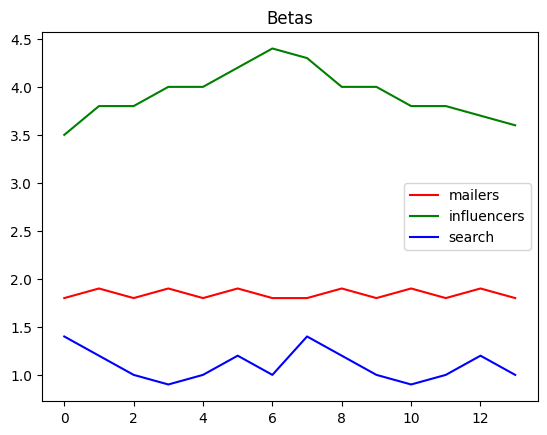

In [9]:
plot_betas(betas, channels, channels_colors)

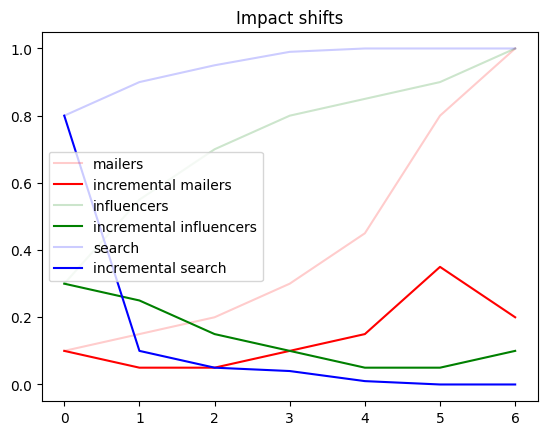

In [10]:
plot_shifts(results, channels, channels_colors)

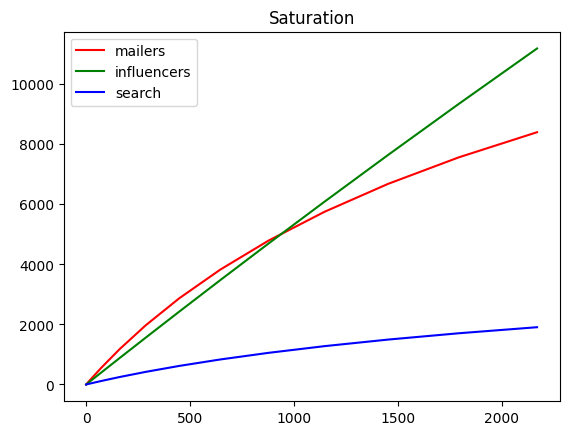

In [11]:
plot_saturation(saturation, channels, channels_colors)

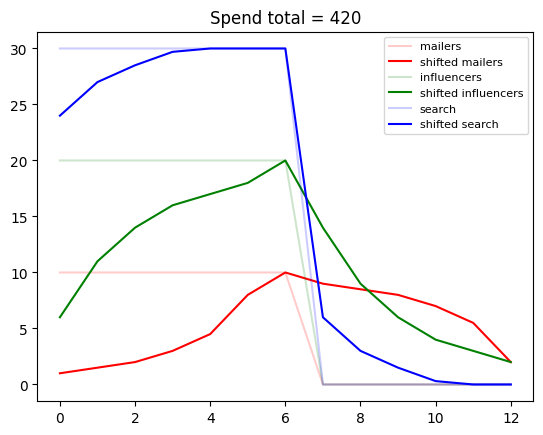

In [12]:
plot_spend(results, channels, channels_colors)

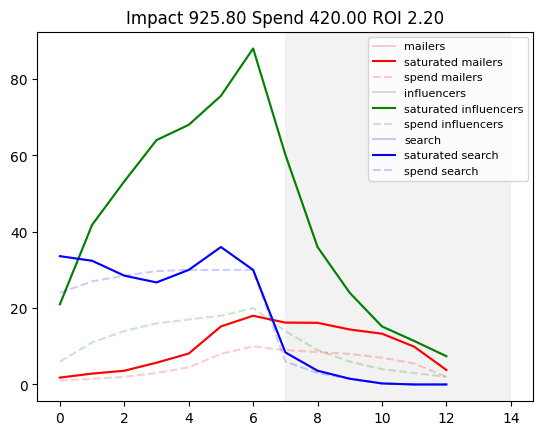

In [13]:
plot_impacts(results, channels, channels_colors)

# Spend spreading

It simulates several budgets with the same budget but with different constant distribution

In [14]:
budget = 4200

test_spends = array = [[[0 for _ in range(len(days))] for _ in range(len(channels))] for _ in range(len(days))]

for d in days:
    value_per_day = budget / (d + 1)
    for c in range(len(channels)):
        for i in range(d + 1):
            test_spends[d][c][i] = value_per_day


In [15]:
test_results = []

for spend in test_spends:
    test_results.append(calculate_impacts(betas, time_shifts, spend, saturation))

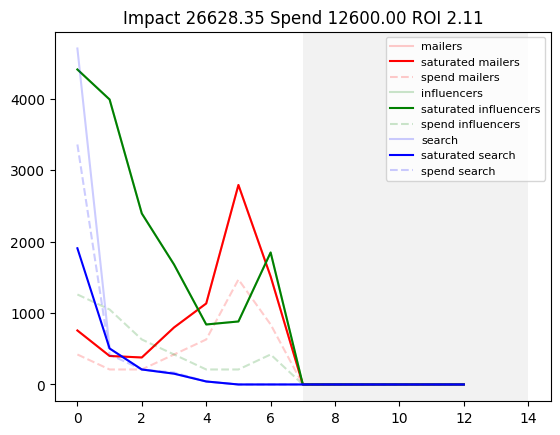

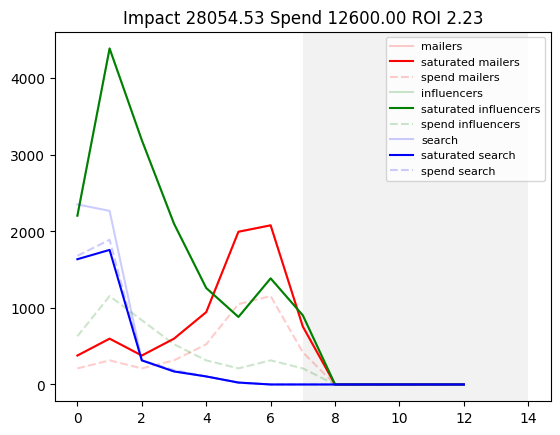

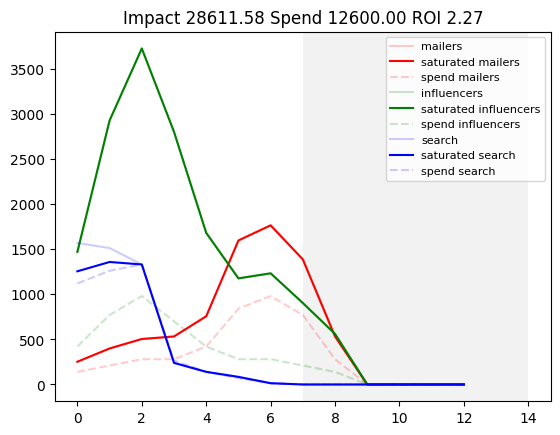

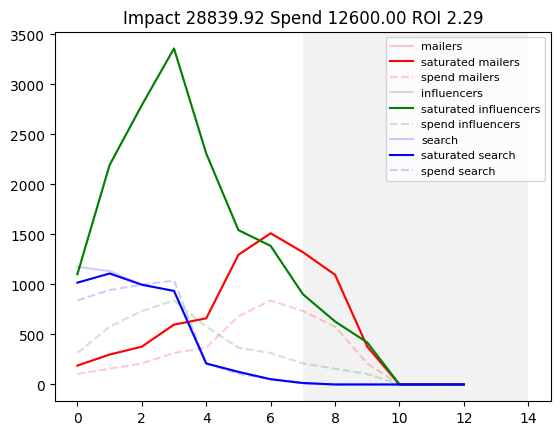

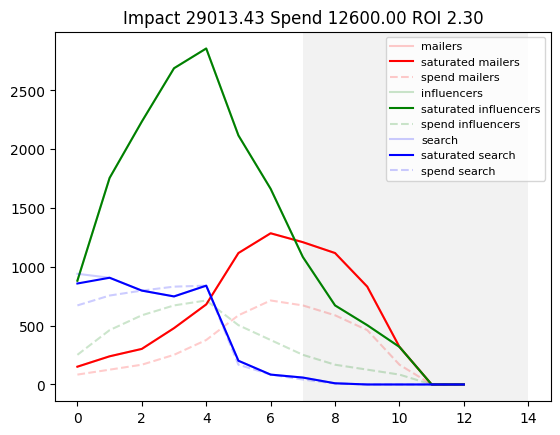

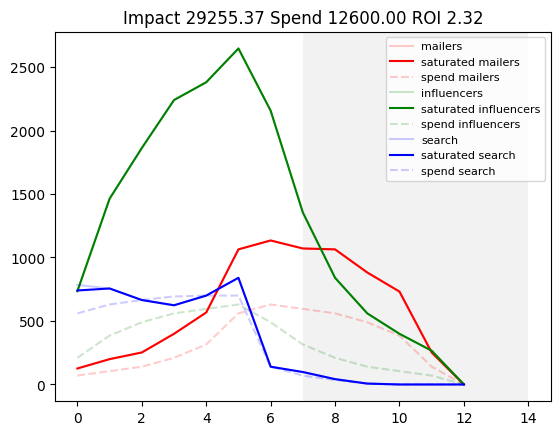

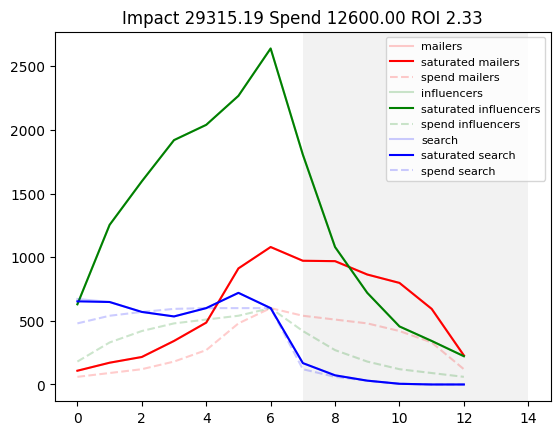

In [16]:
for results in test_results:
    plot_impacts(results, channels, channels_colors)


# Real data

Still using the simplified model but with values coming from a demonstration client

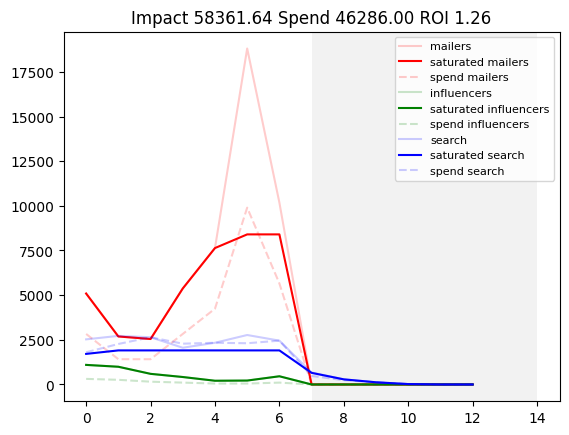

In [17]:
real_spend = [
    [28283,0,0,0,0,0,0],
    [1044,0,0,0,0,0,0],
    [2255,2552,2845,2227,2307,2283,2490]
]
plot_impacts(calculate_impacts(betas, time_shifts, real_spend, saturation), channels, channels_colors)

# Greedy optimizer

It allocates the budget from the channel with the highest average beta to the lowest. It doesn't allocate any spend that can saturate.

## Code

In [18]:
from statistics import mean

def greedy_optimizer(budget, num_days, betas, incremental_shifts, saturation):
    range_channels = range(len(betas))
    range_days = range(num_days)
    extended_range_days = range(num_days + len(incremental_shifts[0]))

    mean_betas = {}
    for c in range_channels:
        mean_betas[c] = mean(betas[c])

    sorted_mean_betas = dict(sorted(mean_betas.items(), key=lambda item: item[1], reverse=True))
    print(sorted_mean_betas)
    
    spend = [[0 for d in range(num_days)] for c in range_channels]
    detailed_spend = [[0 for d in extended_range_days] for c in range_channels]

    remaining_budget = budget
    for c, mean_beta in sorted_mean_betas.items():
        print(f"# channel {c}") 
        print(f"# incremental_shifts {incremental_shifts[c]} = {sum(incremental_shifts[c])}") 
        for d in range_days:
            print(f"\t## day {d}") 
            local_spend = remaining_budget
            while local_spend > 0:
                saturated = False
                local_detailed_spend = detailed_spend[c].copy()
                for i in range(len(incremental_shifts[0])):
                    local_detailed_spend[d + i] += local_spend * incremental_shifts[c][i]
                    local_impact = local_detailed_spend[d + i] * betas[c][d + i]
                    local_saturation = np.interp(local_detailed_spend[d + i], saturation[0], saturation[c + 1])
                    if local_impact > local_saturation:
                        saturated = True
                        break
                if saturated:
                    local_spend = local_spend - 100.0
                else:
                    spend[c][d] = local_spend
                    detailed_spend[c] = local_detailed_spend.copy()
                    print(f"{spend[c]} = {sum(spend[c])}")
                    print(f"{detailed_spend[c]} = {sum(detailed_spend[c])}")
                    remaining_budget = remaining_budget - local_spend
                    break

    return spend


## 50k

{1: 3.9214285714285713, 0: 1.8428571428571427, 2: 1.1}
# channel 1
# incremental_shifts [0.3, 0.25000000000000006, 0.1499999999999999, 0.10000000000000009, 0.04999999999999993, 0.050000000000000044, 0.09999999999999998] = 1.0
	## day 0
[10586.0, 0, 0, 0, 0, 0, 0] = 10586.0
[3175.7999999999997, 2646.5000000000005, 1587.899999999999, 1058.600000000001, 529.2999999999993, 529.3000000000005, 1058.5999999999997, 0, 0, 0, 0, 0, 0, 0] = 10586.0
	## day 1
[10586.0, 900.0, 0, 0, 0, 0, 0] = 11486.0
[3175.7999999999997, 2916.5000000000005, 1812.899999999999, 1193.600000000001, 619.2999999999994, 574.3000000000004, 1103.5999999999997, 89.99999999999999, 0, 0, 0, 0, 0, 0] = 11486.0
	## day 2
[10586.0, 900.0, 3700.0, 0, 0, 0, 0] = 15186.0
[3175.7999999999997, 2916.5000000000005, 2922.8999999999987, 2118.6000000000013, 1174.299999999999, 944.3000000000008, 1288.5999999999995, 275.00000000000017, 369.99999999999994, 0, 0, 0, 0, 0] = 15186.0
	## day 3
[10586.0, 900.0, 3700.0, 2200.0, 0, 0, 0] = 17386.0

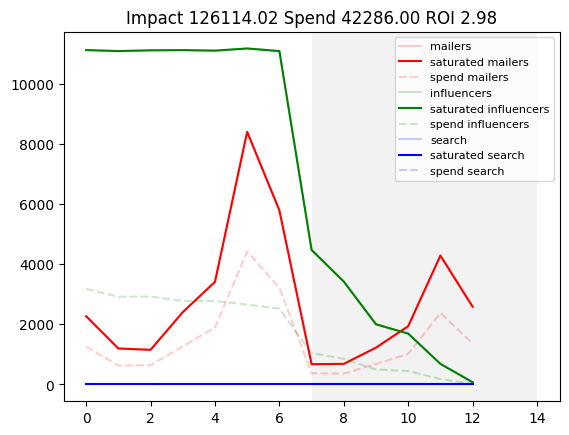

In [61]:
greedy_spend_50k = greedy_optimizer(42286, 7, betas, incremental_shifts, saturation)
plot_impacts(calculate_impacts(betas, time_shifts, greedy_spend_50k, saturation), channels, channels_colors)

## 100k

{1: 3.9214285714285713, 0: 1.8428571428571427, 2: 1.1}
# channel 1
# incremental_shifts [0.3, 0.25000000000000006, 0.1499999999999999, 0.10000000000000009, 0.04999999999999993, 0.050000000000000044, 0.09999999999999998] = 1.0
	## day 0
[10600.0, 0, 0, 0, 0, 0, 0] = 10600.0
[3180.0, 2650.0000000000005, 1589.999999999999, 1060.000000000001, 529.9999999999993, 530.0000000000005, 1059.9999999999998, 0, 0, 0, 0, 0, 0, 0] = 10600.0
	## day 1
[10600.0, 900.0, 0, 0, 0, 0, 0] = 11500.0
[3180.0, 2920.0000000000005, 1814.999999999999, 1195.000000000001, 619.9999999999994, 575.0000000000005, 1104.9999999999998, 89.99999999999999, 0, 0, 0, 0, 0, 0] = 11500.0
	## day 2
[10600.0, 900.0, 3700.0, 0, 0, 0, 0] = 15200.0
[3180.0, 2920.0000000000005, 2924.999999999999, 2120.000000000001, 1174.999999999999, 945.0000000000008, 1289.9999999999995, 275.00000000000017, 369.99999999999994, 0, 0, 0, 0, 0] = 15200.0
	## day 3
[10600.0, 900.0, 3700.0, 2200.0, 0, 0, 0] = 17400.0
[3180.0, 2920.0000000000005, 2924.999

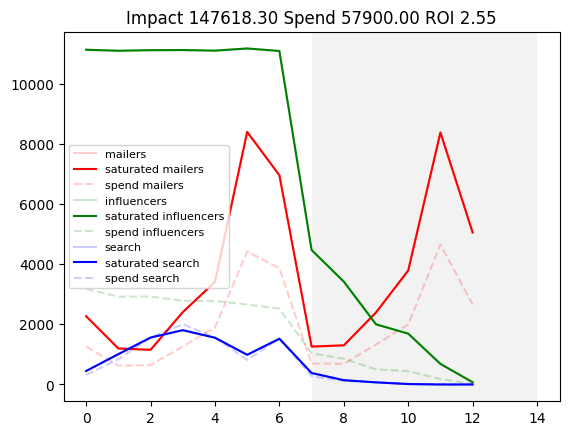

In [20]:
greedy_spend_100k = greedy_optimizer(100000, 7, betas, incremental_shifts, saturation)
plot_impacts(calculate_impacts(betas, time_shifts, greedy_spend_100k, saturation), channels, channels_colors)

## 1M

{1: 3.9214285714285713, 0: 1.8428571428571427, 2: 1.1}
# channel 1
# incremental_shifts [0.3, 0.25000000000000006, 0.1499999999999999, 0.10000000000000009, 0.04999999999999993, 0.050000000000000044, 0.09999999999999998] = 1.0
	## day 0
[10600.0, 0, 0, 0, 0, 0, 0] = 10600.0
[3180.0, 2650.0000000000005, 1589.999999999999, 1060.000000000001, 529.9999999999993, 530.0000000000005, 1059.9999999999998, 0, 0, 0, 0, 0, 0, 0] = 10600.0
	## day 1
[10600.0, 900.0, 0, 0, 0, 0, 0] = 11500.0
[3180.0, 2920.0000000000005, 1814.999999999999, 1195.000000000001, 619.9999999999994, 575.0000000000005, 1104.9999999999998, 89.99999999999999, 0, 0, 0, 0, 0, 0] = 11500.0
	## day 2
[10600.0, 900.0, 3700.0, 0, 0, 0, 0] = 15200.0
[3180.0, 2920.0000000000005, 2924.999999999999, 2120.000000000001, 1174.999999999999, 945.0000000000008, 1289.9999999999995, 275.00000000000017, 369.99999999999994, 0, 0, 0, 0, 0] = 15200.0
	## day 3
[10600.0, 900.0, 3700.0, 2200.0, 0, 0, 0] = 17400.0
[3180.0, 2920.0000000000005, 2924.999

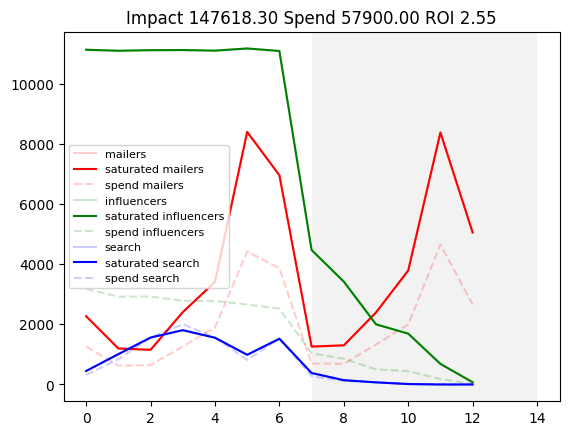

In [21]:
greedy_spend_1m = greedy_optimizer(1000000, 7, betas, incremental_shifts, saturation)
plot_impacts(calculate_impacts(betas, time_shifts, greedy_spend_1m, saturation), channels, channels_colors)

# Solver

## Code v0

In [50]:
import gurobipy as gp
from gurobipy import GRB

C = len(channels)
D = len(days)

B = 46286

model = gp.Model("budget_optimization_1")

x = model.addVars(C, D, lb=0, name="x")

model.setObjective(gp.quicksum(x[c, d] * betas[c][d] for c in range(C) for d in range(D)), GRB.MAXIMIZE)

model.addConstr(gp.quicksum(x[c, d] for c in range(C) for d in range(D)) <= B, name="budget")

model.optimize()

if model.status == GRB.OPTIMAL:
    spend_gurobi_v0 = [[x[c, d].x for d in range(D)] for c in range(C)]
    print(spend_gurobi_v0)

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 1 rows, 21 columns and 21 nonzeros
Model fingerprint: 0x429778da
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [9e-01, 4e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [5e+04, 5e+04]
Presolve removed 1 rows and 21 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    2.0365840e+05   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.02 seconds (0.00 work units)
Optimal objective  2.036584000e+05
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 46286.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]


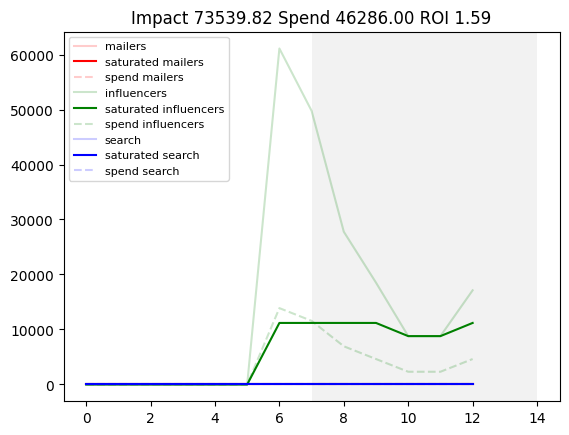

In [51]:
plot_impacts(calculate_impacts(betas, time_shifts, spend_gurobi_v0, saturation), channels, channels_colors)

## Code v1

In [59]:
import gurobipy as gp
from gurobipy import GRB

C = len(channels)
D = len(days)
L = len(incremental_shifts[0])
H = D + L
S = len(saturation[0])

B = 46286

model = gp.Model("budget_optimization_2")

# variables'
x = model.addVars(C, D, lb=0, name="x")
y = model.addVars(C, H, lb=0, name="y")
z = model.addVars(C, H, lb=0, name="z")
alpha = model.addVars(C, H, S, lb=0, vtype=GRB.BINARY, name="alpha")

# objective
model.setObjective(gp.quicksum(z[c, d] for c in range(C) for d in range(H)), GRB.MAXIMIZE)

# constraints
model.addConstr(gp.quicksum(x[c, d] for c in range(C) for d in range(D)) <= B, name="budget")

for c in range(C):
    for d in range(H):
        model.addConstr(
            y[c, d] == gp.quicksum(incremental_shifts[c][d - i] * x[c, i] for i in range(max(0, d - L + 1), min(d + 1, L))),
            name=f"time_shift_{c}_{d}")
for c in range(C):
    for d in range(H):
        model.addConstr(
            z[c, d] <= betas[c][d] * y[c,d],
            name=f"betas_{c}_{d}")
for c in range(C):
    for d in range(H):
        model.addConstr(
            y[c, d] >= gp.quicksum(saturation[0][s] * alpha[c, d, s] for s in range(0, S)),
            name=f"saturation_range_{c}_{d}")
for c in range(C):
    for d in range(H):
        model.addConstr(1 == gp.quicksum(alpha[c, d, s] for s in range(0, S)),
            name=f"only_one_alpha_{c}_{d}")
for c in range(C):
    for d in range(H):
        model.addConstr(z[c, d] <= gp.quicksum(saturation[c + 1][s] * alpha[c, d, s] for s in range(0, S)),
            name=f"saturation_{c}_{d}")

model.write('model01.lp')
model.optimize()

if model.status == GRB.OPTIMAL:
    spend_gurobi = [[x[c, d].x for d in range(D)] for c in range(C)]
    print(spend_gurobi)

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 211 rows, 609 columns and 1792 nonzeros
Model fingerprint: 0x8bf32693
Variable types: 105 continuous, 504 integer (504 binary)
Coefficient statistics:
  Matrix range     [1e-02, 1e+04]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+04]
Found heuristic solution: objective -0.0000000
Presolve removed 43 rows and 133 columns
Presolve time: 0.02s
Presolved: 168 rows, 476 columns, 1564 nonzeros
Variable types: 77 continuous, 399 integer (399 binary)

Root relaxation: objective 1.400664e+05, 138 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Nod

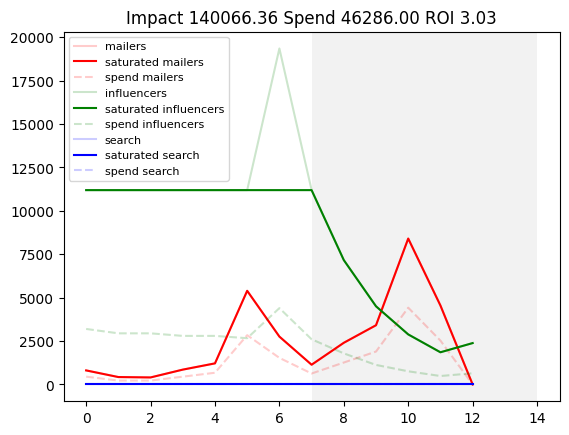

In [60]:
plot_impacts(calculate_impacts(betas, time_shifts, spend_gurobi, saturation), channels, channels_colors)

# Real Models